# Using NBA data from 2000-2019 seasons and putting all of these NBA players into cluster ranged 1-5

## 1: Superstar
## 2: High Level Starter/All Star
## 3: Solid Rotation Player
## 4: Bench/Roleplayer/ok impact
## 5: Bust/Min impact

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

nba_df = pd.read_csv("NBA_2000_2020.csv")

nba_regular = nba_df[nba_df['Season_type'] == 'Regular%20Season'].copy()

# We want to filter for 20+ games played for all NBA players
nba_filtered = nba_regular[nba_regular['GP'] >= 20].copy()

# Calculating Averages of their career stats including efficency rating
player_stats = nba_filtered.groupby('PLAYER').agg({
    'GP': 'mean',
    'MIN': 'mean',
    'PTS': 'mean',
    'REB': 'mean',
    'AST': 'mean',
    'STL': 'mean',
    'BLK': 'mean',
    'FG_PCT': 'mean',
    'FG3_PCT': 'mean',
    'FT_PCT': 'mean',
    'TOV': 'mean',
    'EFF': 'mean',
    'Year': 'count'
}).reset_index()

# Rename 'Year' count to 'Seasons' so it is easier for future work
player_stats.rename(columns={'Year': 'Seasons'}, inplace=True)

print(f"Players after filtering: {len(player_stats)}")
print(player_stats.head())

Players after filtering: 1018
          PLAYER    GP        MIN        PTS       REB    AST       STL  \
0     A.C. Green  82.0  17.200000   4.500000  3.800000  0.500  0.400000   
1   Aaron Brooks  75.0  22.516667  10.583333  1.850000  3.200  0.600000   
2   Aaron Gordon  74.5  29.725000  13.075000  6.675000  2.725  0.775000   
3  Aaron Holiday  66.0  24.500000   9.500000  2.400000  3.400  0.800000   
4    Aaron McKie  77.0  29.800000   9.933333  3.966667  3.700  1.366667   

        BLK    FG_PCT   FG3_PCT    FT_PCT       TOV        EFF  Seasons  
0  0.100000  0.444000  0.000000  0.712000  0.500000   6.100000        1  
1  0.150000  0.410333  0.378333  0.826833  1.683333   8.966667        6  
2  0.625000  0.453250  0.310250  0.698000  1.400000  15.525000        4  
3  0.200000  0.414000  0.394000  0.851000  1.300000   9.800000        1  
4  0.166667  0.453667  0.359333  0.787000  1.833333  12.266667        3  


# Finding features to be used for Clustering

In [12]:
# We want to use the most notable features for NBA players, maybe use weighted features in future
clustering_features = [
    'MIN',
    'PTS',
    'REB',
    'AST',
    'STL',
    'BLK',
    'FG_PCT',
    'FG3_PCT',
    'EFF',
    'TOV'
]

X = player_stats[clustering_features].copy()

X['FG3_PCT'].fillna(0, inplace=True)
X.fillna(X.mean(), inplace=True)

print(X.describe())

               MIN          PTS          REB          AST          STL  \
count  1018.000000  1018.000000  1018.000000  1018.000000  1018.000000   
mean     24.331073     9.943662     4.263933     2.152046     0.763016   
std       6.390941     4.675478     2.122035     1.642939     0.351356   
min       8.700000     1.400000     0.700000     0.200000     0.150000   
25%      19.581250     6.535417     2.721250     1.000000     0.500000   
50%      23.965179     9.033929     3.820000     1.600000     0.700000   
75%      29.137500    12.300000     5.300000     2.900000     0.950000   
max      42.557143    29.500000    14.585714     9.883333     2.314286   

               BLK       FG_PCT      FG3_PCT          EFF          TOV  
count  1018.000000  1018.000000  1018.000000  1018.000000  1018.000000  
mean      0.492669     0.455131     0.279323    11.204181     1.364446  
std       0.462030     0.054041     0.139021     4.637269     0.648822  
min       0.000000     0.293000     0.000

/tmp/ipython-input-2895997280.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['FG3_PCT'].fillna(0, inplace=True)


# Standardizing Features selcted

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")

Scaled data shape: (1018, 10)


# Finding what the optimal Number of Clusters are

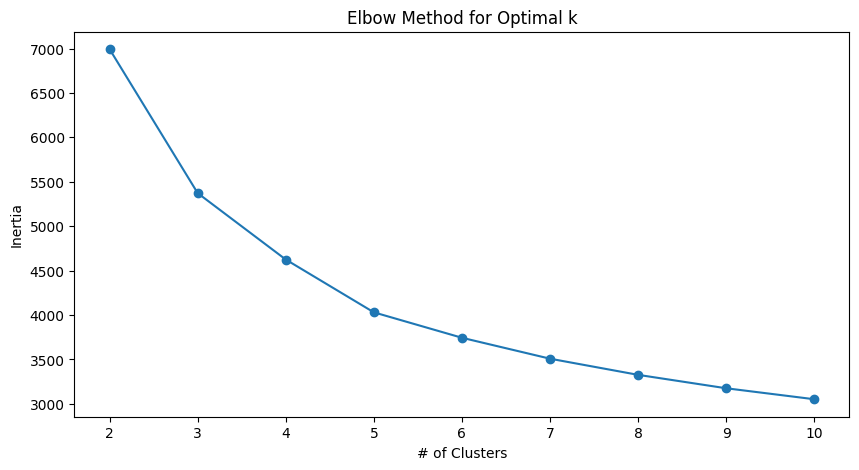

In [14]:
inertias = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Using K-means Clustering Algorithm

In [15]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
player_stats['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster distribution:")
print(player_stats['Cluster'].value_counts().sort_index())


Cluster distribution:
Cluster
0    294
1    178
2    318
3    121
4    107
Name: count, dtype: int64


In [16]:
# First we are analyzing each cluster averages with points, minutes, and efficency rating.
# Then we are ranking the clusters from highest to lowest scoring
# Then we are re mapping the clusters so we can organzie from highest to lowest scoring to verify the superstars
# get placed in the right clusters.
# In the past we were getting a mixture of bad players in superstar categories because the features arn't being weighted by anything

player_stats['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = player_stats.groupby('Cluster')[clustering_features].mean()
print("\nCluster Performance: ")
print(cluster_summary[['PTS', 'MIN', 'EFF']].sort_values('PTS', ascending=False))

cluster_avg_pts = player_stats.groupby('Cluster')['PTS'].mean().sort_values(ascending=False)
print("\nClusters ranked by average PTS:")
print(cluster_avg_pts)

cluster_rank_mapping = {
    old_cluster: new_rank
    for new_rank, old_cluster in enumerate(cluster_avg_pts.index)
}

print("\nCluster mapping:")
print(cluster_rank_mapping)

player_stats['Cluster'] = player_stats['Cluster'].map(cluster_rank_mapping)

cluster_labels = {
    0: 'Superstar',
    1: 'All-Star/Starter',
    2: 'Role Player',
    3: 'Bench',
    4: 'Bust'
}

player_stats['Cluster_Label'] = player_stats['Cluster'].map(cluster_labels)

print("\n" + "="*60)
print("AFTER RELABELING:")
print("="*60)
for i in range(5):
    print(f"\n=== Cluster {i}: {cluster_labels[i]} ===")
    cluster_players = player_stats[player_stats['Cluster'] == i].sort_values('PTS', ascending=False)
    print(cluster_players[['PLAYER', 'PTS', 'MIN', 'EFF']].head(10))


Cluster Performance: 
               PTS        MIN        EFF
Cluster                                 
3        17.524833  33.876276  17.638098
4        13.736492  29.811688  17.919152
0        11.047083  26.956393  11.403165
1         6.654925  19.489094   9.781635
2         6.603521  19.138096   7.108918

Clusters ranked by average PTS:
Cluster
3    17.524833
4    13.736492
0    11.047083
1     6.654925
2     6.603521
Name: PTS, dtype: float64

Cluster mapping:
{3: 0, 4: 1, 0: 2, 1: 3, 2: 4}

AFTER RELABELING:

=== Cluster 0: Superstar ===
               PLAYER        PTS        MIN        EFF
26      Allen Iverson  29.500000  42.557143  22.971429
582       Kobe Bryant  27.321429  38.135714  23.714286
611      LeBron James  27.025000  38.456250  28.856250
567      Kevin Durant  27.018182  36.872727  27.018182
424      James Harden  25.136364  34.300000  24.627273
625       Luka Dončić  25.000000  32.900000  26.200000
192    Damian Lillard  24.437500  36.412500  22.700000
958       

# Analyzing Clusters

In [17]:
cluster_summary = player_stats.groupby('Cluster')[clustering_features].mean()
print("\nCluster Characteristics:")
print(cluster_summary.round(2))

for i in range(5):
    print(f"\n=== Cluster {i} ===")
    cluster_players = player_stats[player_stats['Cluster'] == i].sort_values('PTS', ascending=False)
    print(cluster_players[['PLAYER', 'PTS', 'MIN', 'EFF']].head(10))


Cluster Characteristics:
           MIN    PTS   REB   AST   STL   BLK  FG_PCT  FG3_PCT    EFF   TOV
Cluster                                                                    
0        33.88  17.52  4.60  5.20  1.29  0.36    0.44     0.34  17.64  2.54
1        29.81  13.74  8.48  1.84  0.79  1.29    0.51     0.18  17.92  1.79
2        26.96  11.05  3.74  2.58  0.91  0.32    0.44     0.35  11.40  1.47
3        19.49   6.65  5.13  0.81  0.50  0.80    0.52     0.08   9.78  0.97
4        19.14   6.60  2.72  1.45  0.57  0.27    0.42     0.34   7.11  0.90

=== Cluster 0 ===
               PLAYER        PTS        MIN        EFF
26      Allen Iverson  29.500000  42.557143  22.971429
582       Kobe Bryant  27.321429  38.135714  23.714286
611      LeBron James  27.025000  38.456250  28.856250
567      Kevin Durant  27.018182  36.872727  27.018182
424      James Harden  25.136364  34.300000  24.627273
625       Luka Dončić  25.000000  32.900000  26.200000
192    Damian Lillard  24.437500  36.4

In [18]:
cluster_labels = {
    0: 'Superstar',
    1: 'All-Star/Starter',
    2: 'Role Player',
    3: 'Bench',
    4: 'Bust'
}

player_stats['Cluster_Label'] = player_stats['Cluster'].map(cluster_labels)

print("\nFinal Cluster Distribution:")
print(player_stats['Cluster_Label'].value_counts())

player_stats.to_csv("NBA_Clustered.csv", index=False)


Final Cluster Distribution:
Cluster_Label
Bust                318
Role Player         294
Bench               178
Superstar           121
All-Star/Starter    107
Name: count, dtype: int64


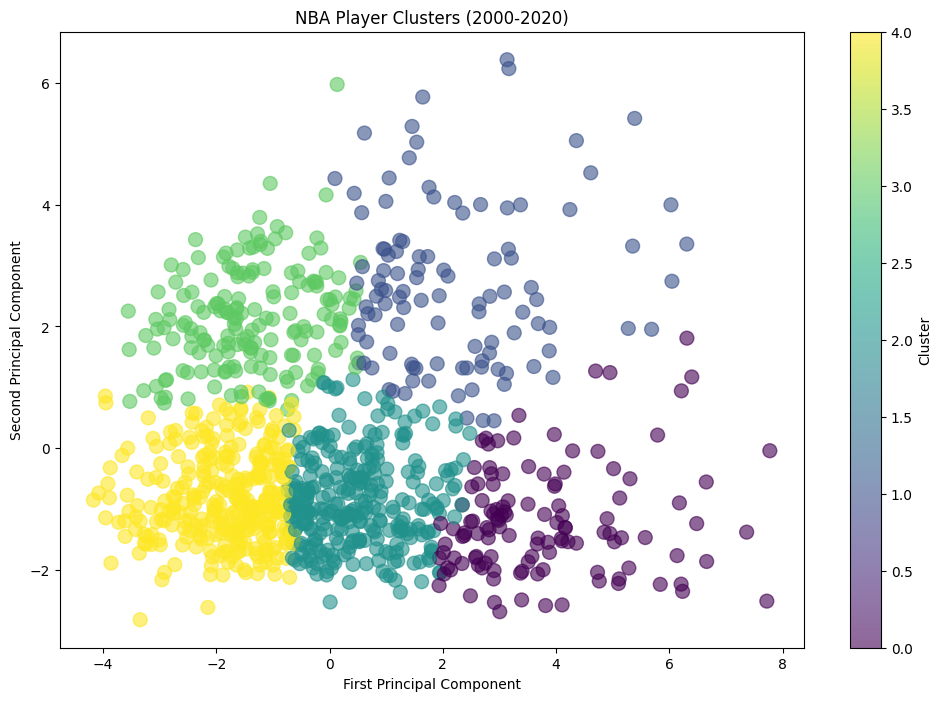

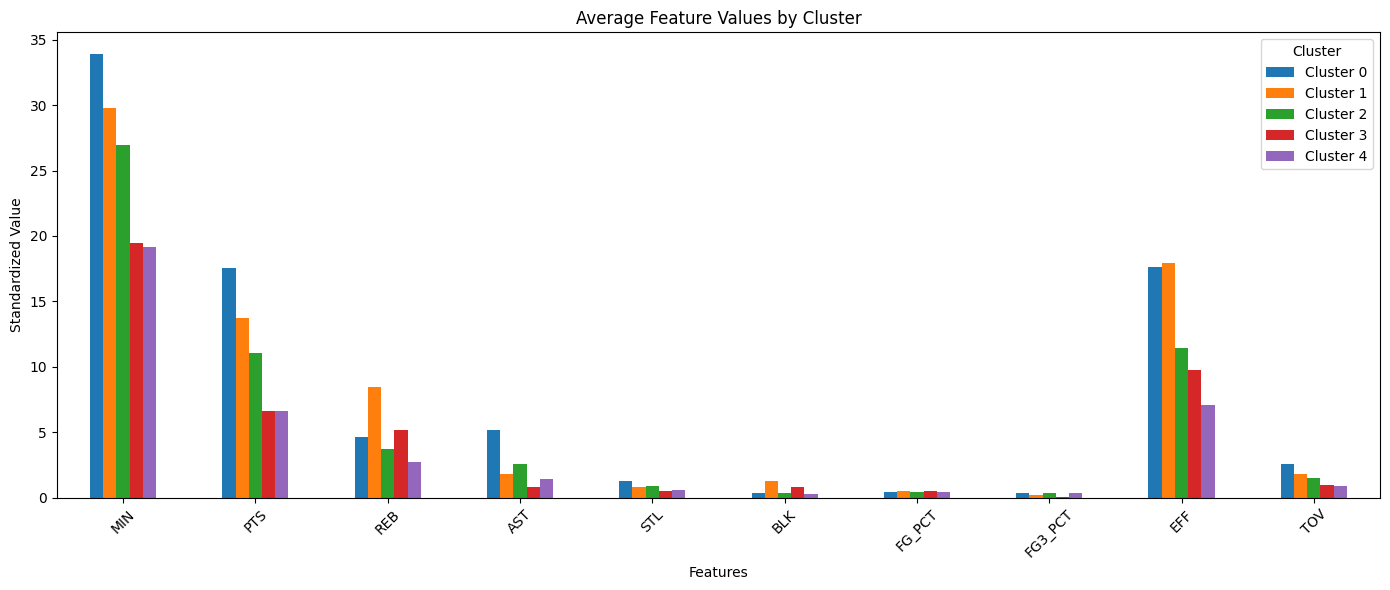

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=player_stats['Cluster'],
                     cmap='viridis',
                     alpha=0.6,
                     s=100)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('NBA Player Clusters (2000-2020)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster means comparison
cluster_summary.T.plot(kind='bar', figsize=(14, 6))
plt.xlabel('Features')
plt.ylabel('Standardized Value')
plt.title('Average Feature Values by Cluster')
plt.legend(title='Cluster', labels=[f'Cluster {i}' for i in range(5)])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()